In [1]:
import random
from os import path

import numpy as np
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import dataloaders
import networks.utils as utils
import networks.wcdcgan_gp as wcdcgan_gp
from networks.utils import compute_kid_score

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data", "tmdb-64")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3  # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
NUM_FEATURE_VEC_CHANNELS = 37
BASE_NUM_OUT_CHANNELS_G = 128
BASE_NUM_OUT_CHANNELS_D = 64
D_NORM_LAYER_TYPE = "instance"
PADDING_MODE = "reflect"
COLORMODE = "RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
BETA1 = 0.  #formerly 0.5
BETA2 = 0.9  #formerly 0.999
N_CRITIC = 5
LAMBDA_GP = 10

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs", "wcdcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 1
SAVE_FAKES_EVERY_N_EPOCHS = 1

MODEL_TO_LOAD = path.join(OUT_PATH, "2022-09-25_23-40-46/gan_at_epoch_0049.pt")
#MODEL_TO_LOAD = None

### Load dataset

In [5]:
# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                           num_workers=NUM_THREADS, pin_memory=True)

Sample dataset:

The dataset has 224094 entries.


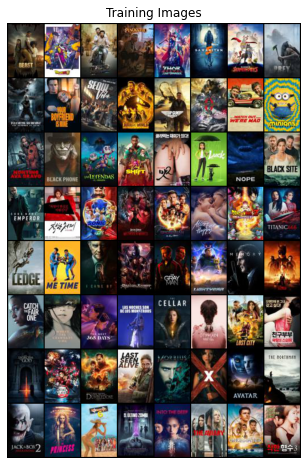

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

In [7]:
sample_labels = torch.stack(sample_reals[6:43], dim=1).type(torch.FloatTensor).to(device)[:NUM_SAMPLES]
sample_labels_generator = sample_labels[:, :, None, None].expand(NUM_SAMPLES, NUM_FEATURE_VEC_CHANNELS, 3, 1)

### Initialize Network

In [8]:
generator, discriminator = wcdcgan_gp.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                                 num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                                 base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G,
                                                 base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D,
                                                 padding_mode=PADDING_MODE,
                                                 num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS,
                                                 d_norm_layer_type=D_NORM_LAYER_TYPE, device=device)

print("Generator:")
summary(generator, input_size=[(NUM_NOISE_VEC_CHANNELS, 3, 1), (NUM_FEATURE_VEC_CHANNELS, 3, 1)])
print("\nDiscriminator:")
summary(discriminator, input_size=[(3, 96, 64), (NUM_FEATURE_VEC_CHANNELS, 96, 64)])

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 6, 4]         819,200
       BatchNorm2d-2            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-3            [-1, 512, 6, 4]         303,104
       BatchNorm2d-4            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-5           [-1, 512, 12, 8]       8,388,608
       BatchNorm2d-6           [-1, 512, 12, 8]           1,024
   ConvTranspose2d-7          [-1, 256, 24, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 24, 16]             512
   ConvTranspose2d-9          [-1, 128, 48, 32]         524,288
      BatchNorm2d-10          [-1, 128, 48, 32]             256
  ConvTranspose2d-11            [-1, 3, 96, 64]           6,144
Total params: 12,142,336
Trainable params: 12,142,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (M

In [9]:
trainer = wcdcgan_gp.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE,
                                    num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO,
                                    d_params=discriminator.parameters(), g_params=generator.parameters(),
                                    learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, n_critic=N_CRITIC,
                                    lambda_gp=LAMBDA_GP, device=device)

## Train

In [10]:
SHOW_GRAPHS = False

trainer.train(generator, discriminator, num_features=NUM_FEATURE_VEC_CHANNELS, dataloader=posterloader,
              num_epochs=NUM_EPOCHS, device=device, model_to_load=MODEL_TO_LOAD, show_graphs=SHOW_GRAPHS,
              fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS,
              model_snap=SAVE_MODEL_EVERY_N_EPOCHS, sample_labels_generator=sample_labels_generator)

[49/53]	Loss_D: -0.7506	Loss_G: -4.1808	D(x): 5.7818	D(G(z)): 4.8674 / 4.1808: 100%|██████████| 3502/3502 [18:24<00:00,  3.17it/s]
[50/53]	Loss_D: -1.1998	Loss_G: -4.4600	D(x): 5.8968	D(G(z)): 4.5240 / 4.4600: 100%|██████████| 3502/3502 [19:06<00:00,  3.06it/s]
[51/53]	Loss_D: -0.9353	Loss_G: -4.2458	D(x): 5.7877	D(G(z)): 4.7085 / 4.2458: 100%|██████████| 3502/3502 [19:08<00:00,  3.05it/s]
[52/53]	Loss_D: -1.3163	Loss_G: -4.8840	D(x): 6.4055	D(G(z)): 4.9418 / 4.8840: 100%|██████████| 3502/3502 [18:46<00:00,  3.11it/s]
[53/53]	Loss_D: -1.1436	Loss_G: -4.6928	D(x): 6.1306	D(G(z)): 4.8392 / 4.6928: 100%|██████████| 3502/3502 [18:53<00:00,  3.09it/s]


### Show results

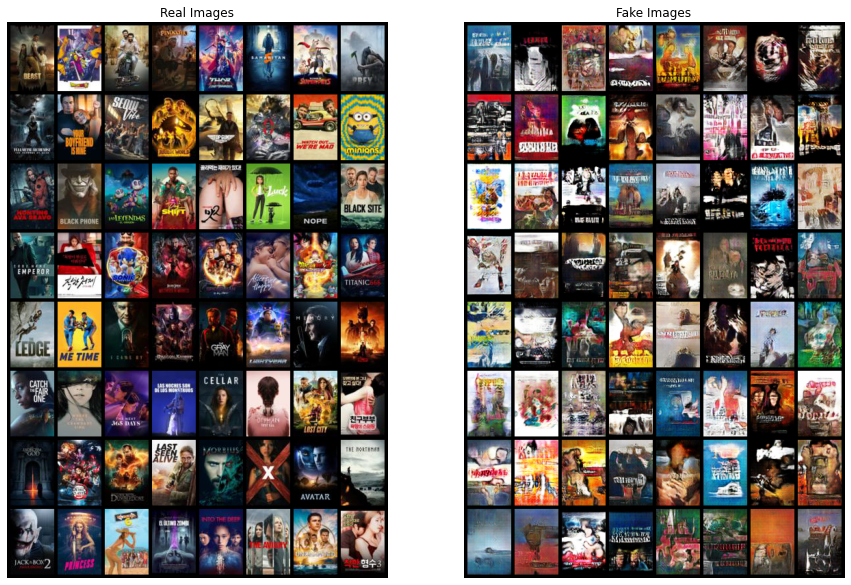

In [11]:
utils.plot_reals_vs_fakes(generator, trainer, sample_reals, NUM_SAMPLES,
                          path.join(trainer.last_out_dir, "real_vs_fake.png"), device,
                          sample_labels_generator=sample_labels_generator)

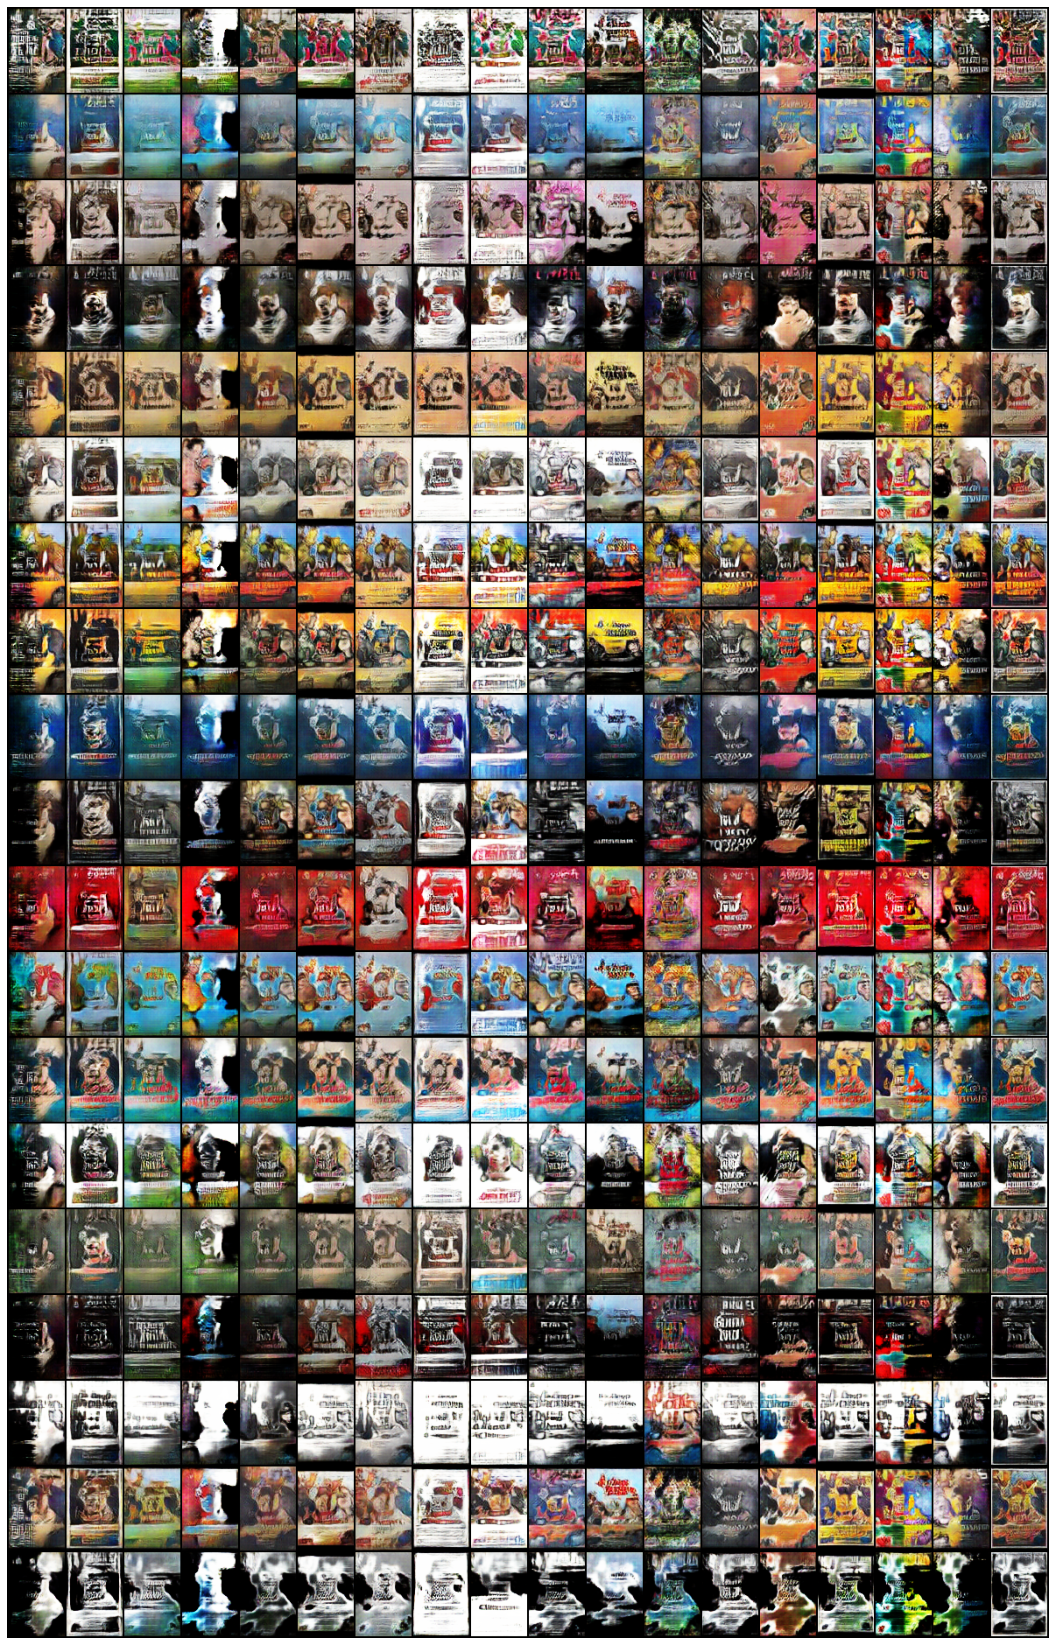

In [16]:
seed = 66666666666
utils.plot_grid(generator, NUM_NOISE_VEC_CHANNELS, device, seed, 20, 30,
                output=path.join(trainer.last_out_dir, "conditional_grid3.png"))

In [13]:
BATCH_SIZE = 500
mode = "generated"
iterations = 5
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)

posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREADS,
                                           pin_memory=PIN_MEMORY)

compute_kid_score(generator, posterloader, mode, iterations, BATCH_SIZE, NUM_NOISE_VEC_CHANNELS, IMAGE_SIZE_RATIO, NUM_FEATURE_VEC_CHANNELS, device)

  0%|          | 0/5 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 5/5 [07:02<00:00, 84.53s/it]

Mode: generated | Mean: 0.3118385374546051 | Std: 2.897041042615456e-07
